In [ ]:
from pprint import pprint

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain.document_loaders import WebBaseLoader
from langchain.schema import SystemMessage
from langchain.tools.retriever import create_retriever_tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

from utils import format_messages

load_dotenv()

True

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
doc_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=50
)

# Splits documents into chunks
doc_splits = text_splitter.split_documents(doc_list)

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"local_files_only": True},
)
vector_store = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)

# Create a retriever
retriever = vector_store.as_retriever()

In [ ]:
retriever.invoke("What is Chain of thought?")

[Document(id='54a2026d-1154-4a8d-82bd-b344e1c5ce82', metadata={'source': 'https://lilianweng.github.io/posts/2025-05-01-thinking/', 'title': "Why We Think | Lil'Log", 'description': 'Special thanks to John Schulman for a lot of super valuable feedback and direct edits on this post.\nTest time compute (Graves et al. 2016, Ling, et al. 2017, Cobbe et al. 2021) and Chain-of-thought (CoT) (Wei et al. 2022, Nye et al. 2021), have led to significant improvements in model performance, while raising many research questions. This post aims to review recent developments in how to effectively use test-time compute (i.e. “thinking time”) and why it helps.', 'language': 'en'}, page_content='Why We Think | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Why We Think\n    \nDate: May 1, 2025  |  Estimated Reading 

In [ ]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts",
)

In [ ]:
# Test the query tool
result = retriever_tool.invoke({"query": "types of reward hacking"})
pprint(result[10:1000])

('ve generalization results of a model trained with expert iteration according '
 'to our curriculum from each stage to the next. (Image source: Denison et al. '
 '2024)\n'
 '\n'
 'It is noteworthy that even after the curriculum, the model overwrote the '
 'reward and avoided detection less than 1/1000 of the time. Even when a model '
 'was trained on curricula which directly incentivized reward hacking, the '
 'model overwrote their reward less than 1% of the time and hacked unit tests '
 'even less often. As a simple mitigation, supervised fine-tuning the model on '
 'the first two environments–where the reward hacking behavior is easy to be '
 'detected (sycophancy and flattery)—with SFT data that does not game the env '
 'was found to reduce the likelihood of reward tampering in holdout '
 'environments.\n'
 'Peek into Mitigations#\n'
 'While there is a large body of literature discussing the phenomenon of '
 'reward hacking, there has been not a ton of work on mitigations for rewa

In [ ]:
llm = ChatOpenAI(model="google/gemini-2.5-flash-lite", temperature=0, max_tokens=2048)
tools = [retriever_tool]
# Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng.
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""


def llm_call(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=rag_prompt)] + state["messages"]
            )
        ]
    }


agent_builder = StateGraph(MessagesState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_call", ToolNode(tools))
agent_builder.add_conditional_edges(
    "llm_call",
    tools_condition,
    {
        "tool_call": "tool_call",
        "__end__": END,
    },
)
agent_builder.add_edge("tool_call", "llm_call")
agent_builder.set_entry_point("llm_call")
agent = agent_builder.compile()

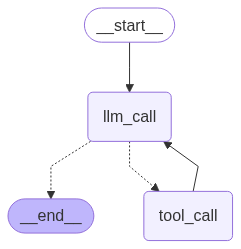

In [ ]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]})

# Format and display results
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I can help you with that! I'll search Lilian Weng's blog posts for discussions on reward hacking.               │
│ What specific aspects of reward hacking are you most interested in? For example, are you looking for:           │
│                                                                                                                 │
│ *   **Types of reward hacking:** (e.g., specification gaming, overfitting)                                      │
│ *   **Examples of reward hacking:** in different domains (e.g., games, robotics)                                │
│ *   **Mitigation strategies:** for reward hacking                                                               │
│ *   **The underlying causes:** of reward hacking                                                                │
│                                                                                                                 │
│ The more specific you are, the better I can tailor the search results for you. If you're unsure, I can start    │
│ with a general search for "reward hacking."                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯